# XAI for Sea Ice Classification of Waveform Characteristics

This notebook demonstrates techniques for classifying sea ice and leads from waveform data using both deep learning and tree-based methods and the ways to show which waveform characteristics contributes the most to the classification.

## Models Implemented

- **CNN**: Captures patterns directly from raw waveforms  
- **Random Forest**: Robust ensemble approach with inherent feature importance  
- **Gradient Boosting**: Sequential learning focused on misclassification correction  
- **XGBoost**: Optimised gradient boosting with regularisation  

## Key Analysis Techniques

- Preprocessing of waveform characteristics
- SHAP values for CNN interpretability  
- Model comparison with confusion matrices
- Identification of consensus important regions across models  

The notebook identifies which waveform characteristics are most discriminative for sea ice classification, offering insights that may improve for waveform classification.


## 1. Data Preprocessing

- Reads waveform data from a CSV file and processes it into structured arrays.   
- Handles missing values and class label inconsistencies.  
- Splits data into training and test sets while scaling features for consistency.  

---

## 2. CNN Model for Waveform Classification

- Implements a Convolutional Neural Network (CNN) to classify sea ice and leads from radar waveform characteristics.  
- Uses multiple convolutional layers with batch normalisation, max pooling, dropout, and dense layers.  
- Compiles with the Adam optimizer and binary cross-entropy loss, monitoring performance with accuracy and AUC metrics.  
- Trains with early stopping and learning rate reduction strategies to prevent overfitting.  
- Plots training history to assess model performance over epochs.  

---

## 3. Model Evaluation & Explainability (SHAP & Gradients)

- Evaluates the trained CNN model on the test set, reporting accuracy, confusion matrix, and classification metrics.  
- Uses **SHAP (SHapley Additive Explanations)** values to interpret feature importance, identifying key waveform regions influencing classification.   
- Helps in understanding which waveform characteristics contribute most to sea ice classification decisions.  


We need to install GPY and restart session as we did in our last notebook.

In [ ]:
!pip install Gpy

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import ast
from scipy.optimize import curve_fit
from scipy.stats import median_abs_deviation
import shap

# Function to parse string representation of waveform array into numeric values
def parse_waveform(waveform_str):
    """Parse the string representation of waveform array into numeric values"""
    cleaned_str = waveform_str.replace('e+', 'e').replace(' ', '')

    try:
        # Use ast.literal_eval for safe evaluation of the string as a list
        waveform_list = ast.literal_eval(cleaned_str)
        return np.array(waveform_list)
    except (SyntaxError, ValueError) as e:
        try:
            # Manual parsing fallback
            values_str = waveform_str.strip('[]').split(',')
            values = []
            for val in values_str:
                val = val.strip()
                if val:  # Skip empty strings
                    values.append(float(val))
            return np.array(values)
        except Exception as e2:
            print(f"Error parsing waveform: {e2}")
            return np.array([])

# ----- Waveform Feature Extraction Functions -----

def extract_waveform_features(waveform):
    """Extract features from a radar waveform as described in the literature"""
    features = {}

    # Normalize waveform for relative measurements
    if np.max(waveform) > 0:
        norm_waveform = waveform / np.max(waveform)
    else:
        norm_waveform = waveform.copy()

    # 1. Leading Edge Width (LEW)
    # Find the positions where the waveform crosses 30% and 70% thresholds on rising edge
    try:
        # Find the maximum position
        max_idx = np.argmax(norm_waveform)

        # Find indexes before the peak where waveform crosses 30% and 70% thresholds
        thresh_30_idx = None
        thresh_70_idx = None

        for i in range(max_idx):
            if norm_waveform[i] <= 0.3 and norm_waveform[i+1] > 0.3:
                # Interpolate to find more precise bin position
                frac = (0.3 - norm_waveform[i]) / (norm_waveform[i+1] - norm_waveform[i])
                thresh_30_idx = i + frac
            if norm_waveform[i] <= 0.7 and norm_waveform[i+1] > 0.7:
                # Interpolate to find more precise bin position
                frac = (0.7 - norm_waveform[i]) / (norm_waveform[i+1] - norm_waveform[i])
                thresh_70_idx = i + frac

        # If thresholds weren't found before peak, use default values
        if thresh_30_idx is None or thresh_70_idx is None:
            features['lew'] = np.nan
        else:
            features['lew'] = thresh_70_idx - thresh_30_idx
    except:
        features['lew'] = np.nan

    # 2. Waveform Maximum (Wm)
    features['wm'] = np.max(waveform)

    # 3. Trailing Edge Decline (Ted)
    try:
        # Exponential decay function for fitting
        def exp_decay(x, a, b):
            return a * np.exp(-b * x)

        max_idx = np.argmax(waveform)
        trailing_edge = waveform[max_idx:]

        if len(trailing_edge) > 3:  # Need at least a few points for fitting
            x_data = np.arange(len(trailing_edge))

            # Avoid curve_fit errors by ensuring positive values
            trailing_edge_pos = np.maximum(trailing_edge, 1e-10)

            # Initial guess for parameters
            p0 = [trailing_edge_pos[0], 0.1]

            try:
                # Fit exponential decay to trailing edge
                popt, _ = curve_fit(exp_decay, x_data, trailing_edge_pos, p0=p0, maxfev=1000)
                features['ted'] = popt[1]  # Decay rate parameter
            except:
                features['ted'] = np.nan
        else:
            features['ted'] = np.nan
    except:
        features['ted'] = np.nan

    # 4. Waveform Noise (Wn) - MAD of trailing edge residuals
    try:
        max_idx = np.argmax(waveform)
        trailing_edge = waveform[max_idx:]

        if len(trailing_edge) > 3 and 'ted' in features and not np.isnan(features['ted']):
            # Using the fitted parameters from Ted
            x_data = np.arange(len(trailing_edge))
            fitted_values = features['wm'] * np.exp(-features['ted'] * x_data)

            # Calculate residuals
            residuals = trailing_edge - fitted_values

            # MAD of residuals
            features['wn'] = median_abs_deviation(residuals, scale=1.0)
        else:
            features['wn'] = np.nan
    except:
        features['wn'] = np.nan

    # 5. Waveform Width (Ww)
    # Count bins with power > 0
    features['ww'] = np.sum(waveform > 0)

    # 6. Leading Edge Slope (Les)
    try:
        max_idx = np.argmax(norm_waveform)

        # Find bins where waveform exceeds 30% of max
        thresh_30_idx = None
        for i in range(max_idx):
            if norm_waveform[i] <= 0.3 and norm_waveform[i+1] > 0.3:
                thresh_30_idx = i
                break

        if thresh_30_idx is not None:
            # Calculate difference between max bin and first 30% threshold bin
            features['les'] = max_idx - thresh_30_idx
        else:
            features['les'] = np.nan
    except:
        features['les'] = np.nan

    # 7. Trailing Edge Slope (Tes)
    try:
        max_idx = np.argmax(norm_waveform)

        # Find last bin where waveform exceeds 30% of max
        thresh_30_idx = None
        for i in range(len(norm_waveform)-1, max_idx, -1):
            if norm_waveform[i] <= 0.3 and norm_waveform[i-1] > 0.3:
                thresh_30_idx = i
                break

        if thresh_30_idx is not None:
            # Calculate difference between last 30% threshold bin and max bin
            features['tes'] = thresh_30_idx - max_idx
        else:
            features['tes'] = np.nan
    except:
        features['tes'] = np.nan

    # 8. Pulse Peakiness (PP) - common waveform feature in literature
    try:
        features['pp'] = features['wm'] / np.mean(waveform)
    except:
        features['pp'] = np.nan

    # 9. Max position (relative bin where the maximum occurs)
    try:
        features['max_pos'] = np.argmax(waveform) / len(waveform)
    except:
        features['max_pos'] = np.nan

    return features

def extract_waveforms_and_features(roughness, target_column):
    """Process all waveforms and extract features"""
    # Lists to store data
    feature_list = []
    target_list = []
    valid_indices = []
    raw_waveforms = []

    print("Extracting features from waveforms...")

    # Process each row
    for idx, row in roughness.iterrows():
        if idx % 500 == 0:
            print(f"Processing row {idx}/{len(roughness)}...")

        try:
            # Get the waveform and class
            waveform_str = str(row['Matched_Waveform_20_Ku'])
            waveform_array = parse_waveform(waveform_str)

            # Get class label
            class_label = int(row[target_column])

            # Extract features if valid waveform
            if len(waveform_array) > 0:
                # Extract features
                features = extract_waveform_features(waveform_array)

                # Skip if any feature is NaN
                if np.any(np.isnan(list(features.values()))):
                    continue

                # Store data
                feature_list.append(list(features.values()))
                target_list.append(class_label)
                valid_indices.append(idx)
                raw_waveforms.append(waveform_array)

        except Exception as e:
            if idx < 5:  # Print first few errors
                print(f"Error processing row {idx}: {e}")
            continue

    # Convert to numpy arrays
    X_features = np.array(feature_list)
    y = np.array(target_list)
    X_raw = np.array(raw_waveforms)

    # Create feature names
    feature_names = ['Leading Edge Width', 'Waveform Maximum',
                     'Trailing Edge Decline', 'Waveform Noise',
                     'Waveform Width', 'Leading Edge Slope',
                     'Trailing Edge Slope', 'Pulse Peakiness',
                     'Max Position']

    return X_features, y, X_raw, valid_indices, feature_names



In [4]:
# ----- Main Processing -----
roughness = pd.read_csv('/content/drive/MyDrive/GEOL0069/2324/Week 9 2025/updated_filtered_matched_uit_sentinel3_L2_alongtrack_2023_04_official.txt')
print(roughness)
print("Starting waveform feature extraction and classification...")

# Define the target column
target_column = 'Sea_Ice_Class'
if target_column not in roughness.columns:
    print(f"Warning: {target_column} not found. Available columns: {roughness.columns}")
    print("Will use 'Lead_Class' as target instead.")
    target_column = 'Lead_Class'

# Extract features from all waveforms
X_features, y, X_raw, valid_indices, feature_names = extract_waveforms_and_features(roughness, target_column)

print(f"Extracted {len(feature_names)} features from {len(X_features)} valid waveforms")
print(f"Features: {feature_names}")
print(f"Feature data shape: {X_features.shape}")
print(f"Class distribution: {np.bincount(y)}")

# Check for NaN values
nan_mask = np.isnan(X_features).any(axis=1)
X_features_clean = X_features[~nan_mask]
y_clean = y[~nan_mask]
X_raw_clean = X_raw[~nan_mask]

print(f"Removed {np.sum(nan_mask)} samples with NaN values")
print(f"Clean feature data shape: {X_features_clean.shape}")

# Split data into training and test sets
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(
    X_features_clean, y_clean, X_raw_clean,
    test_size=0.2, random_state=42, stratify=y_clean
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

       3A=0_3B=1  Orbit_#  Segment_#     Datenumber   Latitude  Longitude  \
0              0        1          1  738977.028790  74.432732 -73.103512   
1              0        1          1  738977.028790  74.435182 -73.109831   
2              0        1          1  738977.028791  74.437633 -73.116151   
3              0        1          1  738977.028791  74.440083 -73.122474   
4              0        1          1  738977.028792  74.442533 -73.128797   
...          ...      ...        ...            ...        ...        ...   
28720          0      843        843  739006.699439  71.763165 -74.486482   
28721          0      843        843  739006.699440  71.760574 -74.491177   
28722          0      843        843  739006.699440  71.757982 -74.495872   
28723          0      843        843  739006.699450  71.711313 -74.580159   
28724          0      843        843  739006.699451  71.708719 -74.584830   

       Radar_Freeboard  Surface_Height_WGS84  Sea_Surface_Height_Interp_WGS

       3A=0_3B=1  Orbit_#  Segment_#     Datenumber   Latitude  Longitude  \
0              0        1          1  738977.028790  74.432732 -73.103512   
1              0        1          1  738977.028790  74.435182 -73.109831   
2              0        1          1  738977.028791  74.437633 -73.116151   
3              0        1          1  738977.028791  74.440083 -73.122474   
4              0        1          1  738977.028792  74.442533 -73.128797   
...          ...      ...        ...            ...        ...        ...   
28720          0      843        843  739006.699439  71.763165 -74.486482   
28721          0      843        843  739006.699440  71.760574 -74.491177   
28722          0      843        843  739006.699440  71.757982 -74.495872   
28723          0      843        843  739006.699450  71.711313 -74.580159   
28724          0      843        843  739006.699451  71.708719 -74.584830   

       Radar_Freeboard  Surface_Height_WGS84  Sea_Surface_Height_Interp_WGS

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 16)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 337 (1.32 KB)

 Non-trainable params: 32 (128.00 B)

Detected class imbalance, applying class weights

Training neural network model...
Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5987 - auc_1: 0.5160 - loss: 1.0171 - val_accuracy: 0.5859 - val_auc_1: 0.9090 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6790 - auc_1: 0.8197 - loss: 0.5255 - val_accuracy: 0.6721 - val_auc_1: 0.9266 - val_loss: 0.4585 - learning_rate: 0.0010
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7154 - auc_1: 0.8620 - loss: 0.4470 - val_accuracy: 0.7367 - val_auc_1: 0.9282 - val_loss: 0.3785 - learning_rate: 0.0010
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7772 - auc_1: 0.8951 - loss: 0.4121 - val_accuracy: 0.7288 - val_auc_1: 0.9296 - val_loss: 0.3542 - learning_rate: 0.0010
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7839 - auc_1: 0.9084 - loss: 0.3748 - val_accuracy: 0.7239 - val_auc_1: 0.9302 - val_loss: 0.3491 

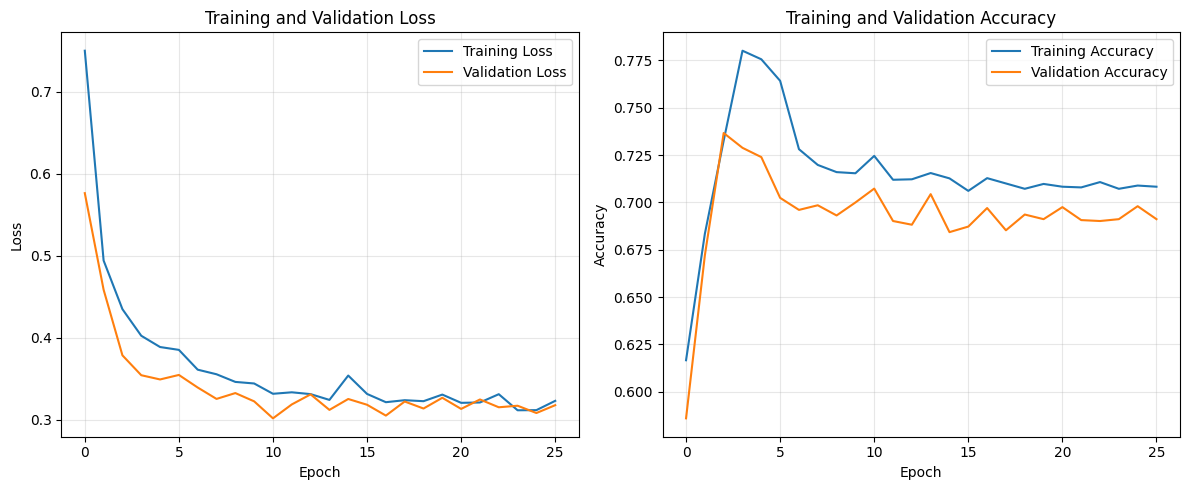

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Accuracy: 0.7086

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.98      0.24       121
           1       1.00      0.69      0.82      2432

    accuracy                           0.71      2553
   macro avg       0.57      0.84      0.53      2553
weighted avg       0.96      0.71      0.79      2553



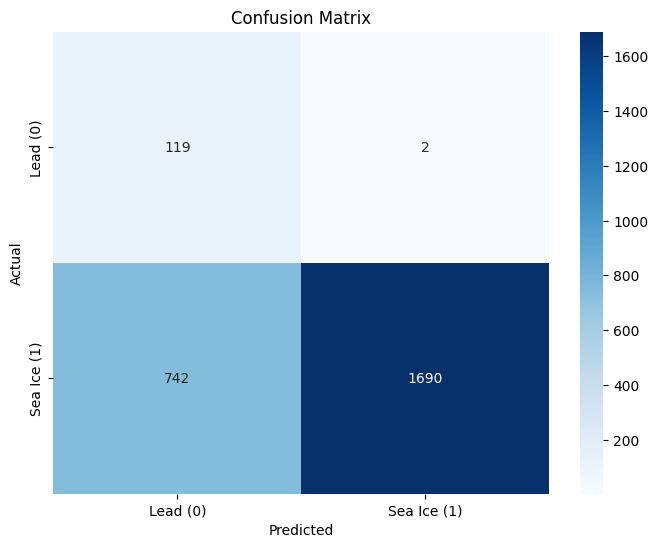

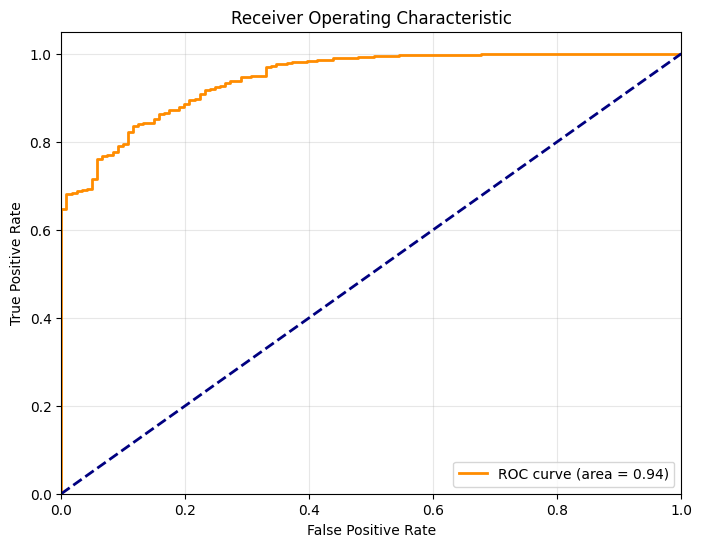

In [9]:


# ----- Neural Network Model for Feature-Based Classification -----

# Build a simple neural network model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Model summary
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
]

# Apply class weights if imbalanced
class_weights = None
if len(np.unique(y_train)) > 1:
    n_samples = len(y_train)
    n_classes = len(np.unique(y_train))
    class_counts = np.bincount(y_train)
    if np.min(class_counts) / np.max(class_counts) < 0.5:  # If imbalanced
        print("Detected class imbalance, applying class weights")
        class_weights = {i: n_samples / (n_classes * count) for i, count in enumerate(class_counts)}

# Train the model
print("\nTraining neural network model...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----- Model Evaluation -----


y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lead (0)', 'Sea Ice (1)'],
            yticklabels=['Lead (0)', 'Sea Ice (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()





Calculating feature importance using SHAP values...


ExactExplainer explainer: 2554it [00:45, 46.92it/s]                          



Feature Importance Ranking:
Leading Edge Width: 0.0947
Pulse Peakiness: 0.0826
Leading Edge Slope: 0.0653
Trailing Edge Slope: 0.0598
Waveform Maximum: 0.0378
Trailing Edge Decline: 0.0332
Waveform Noise: 0.0253
Max Position: 0.0145
Waveform Width: 0.0000


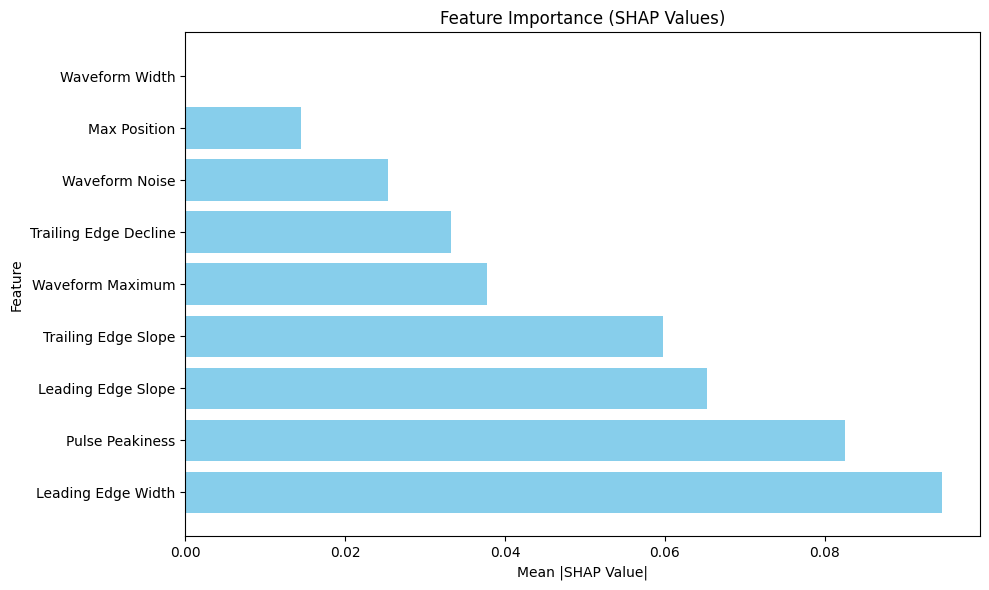

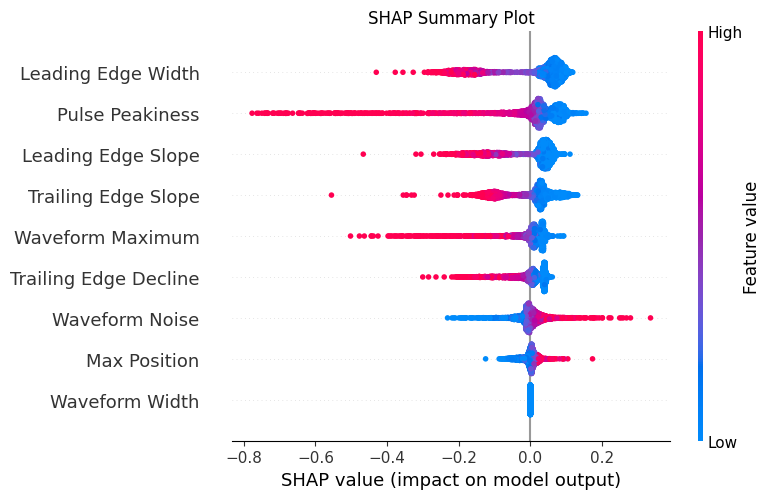

Waveform feature-based classification complete!


In [8]:
# ----- Feature Importance Analysis -----

# Use SHAP for feature importance
print("\nCalculating feature importance using SHAP values...")

try:
    # Create an explainer for the model
    explainer = shap.Explainer(model, X_train_scaled)
    shap_values = explainer(X_test_scaled)

    # Get mean absolute SHAP values for feature importance
    feature_importance = np.abs(shap_values.values).mean(0)

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance Ranking:")
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Mean |SHAP Value|')
    plt.ylabel('Feature')
    plt.title('Feature Importance (SHAP Values)')
    plt.tight_layout()
    plt.show()

    # Plot SHAP summary plot (this shows direction of impact too)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()



except Exception as e:
    print(f"Error calculating SHAP values: {e}")

    # Simple feature importance from model weights (for dense layers)
    # This is a simpler approach that works when SHAP fails
    weights = model.layers[0].get_weights()[0]
    importance = np.abs(weights).mean(axis=1)

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance Ranking (from model weights):")
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Absolute Weight Magnitude')
    plt.ylabel('Feature')
    plt.title('Feature Importance (Neural Network Weights)')
    plt.tight_layout()
    plt.show()

print("Waveform feature-based classification complete!")

## 4. Tree-Based Classification Models with Engineered Waveform Features

### **Random Forest**
- Trains a **Random Forest Classifier** with 100 trees and class balancing on extracted waveform features.  
- Evaluates model performance using accuracy and classification metrics.  
- Ranks feature importance to identify the most influential waveform characteristics (e.g., **Pulse Peakiness, Leading Edge Width**).  

### **Gradient Boosting**
- Implements a **Gradient Boosting Classifier** on waveform features, optimising misclassified samples.  
- Evaluates model performance using accuracy and classification metrics.  
- Ranks feature importance to identify the most influential waveform characteristics (e.g., **Pulse Peakiness, Leading Edge Width**).  

### **XGBoost**
- Trains an **XGBoost Classifier** using engineered waveform features, leveraging regularised gradient boosting.  
- Evaluates model performance using accuracy and classification metrics.  
- Ranks feature importance to identify the most influential waveform characteristics (e.g., **Pulse Peakiness, Leading Edge Width**).  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Function to plot feature importance overlaid on average waveforms
def plot_importance_on_waveform(feature_importance, model_name, X_clean, y_clean):
    plt.figure(figsize=(15, 6))

    # Plot average waveforms
    waveforms_class0 = X_clean[y_clean == 0]
    waveforms_class1 = X_clean[y_clean == 1]

    if len(waveforms_class0) > 0:
        plt.plot(np.mean(waveforms_class0, axis=0), 'b-', label='Lead (Class 0)', alpha=0.5)
    if len(waveforms_class1) > 0:
        plt.plot(np.mean(waveforms_class1, axis=0), 'r-', label='Sea Ice (Class 1)', alpha=0.5)

    # Scale importance for visualization
    max_wave_amp = max(
        np.max(np.mean(waveforms_class0, axis=0)) if len(waveforms_class0) > 0 else 0,
        np.max(np.mean(waveforms_class1, axis=0)) if len(waveforms_class1) > 0 else 0
    )

    if max(feature_importance) > 0:  # Avoid division by zero
        importance_scaling = max_wave_amp / max(feature_importance) * 2
        plt.bar(range(len(feature_importance)),
                feature_importance * importance_scaling,
                alpha=0.3,
                color='g',
                label='Feature Importance')

    plt.title(f'{model_name}: Feature Importance vs. Waveform Patterns')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude / Importance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

=== Training Random Forest Classifier with Waveform Features ===
Random Forest Accuracy: 0.9749

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.63      0.70       121
           1       0.98      0.99      0.99      2432

    accuracy                           0.97      2553
   macro avg       0.89      0.81      0.85      2553
weighted avg       0.97      0.97      0.97      2553



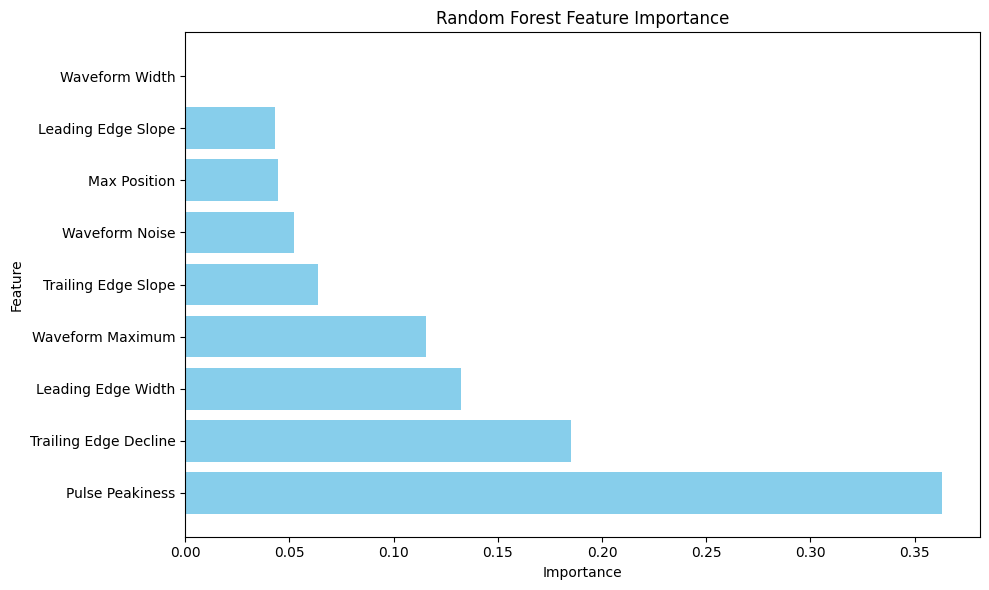

In [11]:
from sklearn.ensemble import RandomForestClassifier

print("=== Training Random Forest Classifier with Waveform Features ===")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

# Train the model on extracted features
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Get feature importance
feature_importance_rf = rf_model.feature_importances_

# Create feature importance visualization
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_rf
}).sort_values('Importance', ascending=False)

plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

=== Training Gradient Boosting Classifier with Waveform Features ===
Gradient Boosting Accuracy: 0.9738

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.60      0.68       121
           1       0.98      0.99      0.99      2432

    accuracy                           0.97      2553
   macro avg       0.89      0.79      0.83      2553
weighted avg       0.97      0.97      0.97      2553



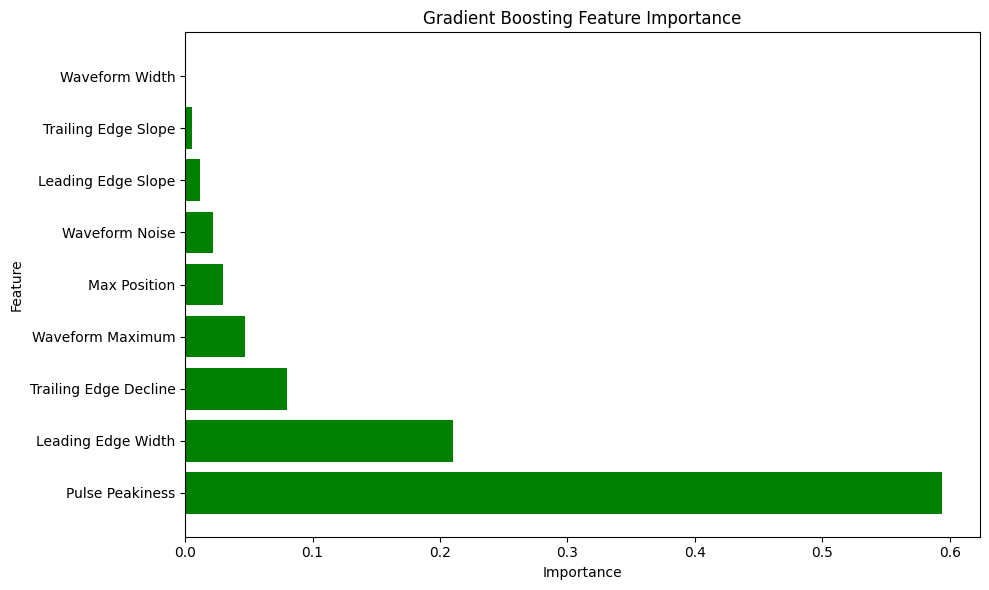

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

print("=== Training Gradient Boosting Classifier with Waveform Features ===")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    random_state=42
)

# Train the model on extracted features
gb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

# Get feature importance
feature_importance_gb = gb_model.feature_importances_

# Create feature importance visualization
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_gb
}).sort_values('Importance', ascending=False)

plt.barh(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Feature Importance')
plt.tight_layout()
plt.show()

=== Training XGBoost Classifier with Waveform Features ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9745

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.57      0.68       121
           1       0.98      0.99      0.99      2432

    accuracy                           0.97      2553
   macro avg       0.91      0.78      0.83      2553
weighted avg       0.97      0.97      0.97      2553



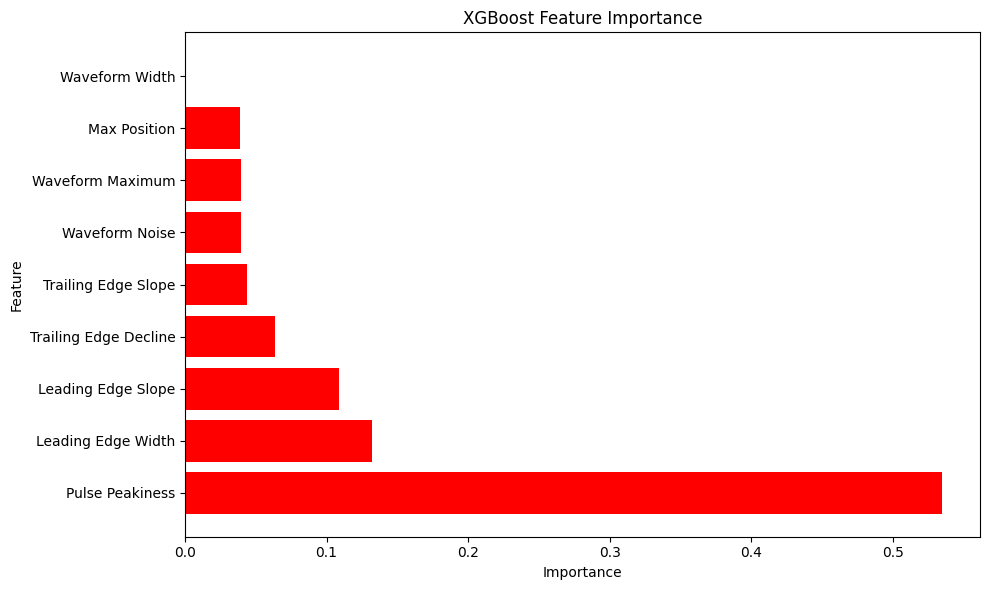

In [13]:
import xgboost as xgb

print("=== Training XGBoost Classifier with Waveform Features ===")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model on extracted features
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Get feature importance
feature_importance_xgb = xgb_model.feature_importances_

# Create feature importance visualization
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_xgb
}).sort_values('Importance', ascending=False)

plt.barh(importance_df['Feature'], importance_df['Importance'], color='red')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()